In [1]:
import numpy as np

import readligo as rl
from gwpy.table import EventTable
from gwpy.timeseries import TimeSeries

import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import gwpy
print(gwpy.__version__) # 2.0.2

2.0.2


In [2]:
eventtable = EventTable.fetch_open_data("GWTC-1-confident")
eventtable['commonName'].tolist()

['GW150914',
 'GW151012',
 'GW151226',
 'GW170104',
 'GW170608',
 'GW170729',
 'GW170809',
 'GW170814',
 'GW170817',
 'GW170818',
 'GW170823']

- Select a GW events

In [3]:
# BBH
event_name = 'GW150914'
# event_name = 'GW151012'
# event_name = 'GW151226'
# event_name = 'GW170104'
# event_name = 'GW170608'
# event_name = 'GW170729'
# event_name = 'GW170809'
# event_name = 'GW170814'
# event_name = 'GW170818'
# event_name = 'GW170823'

---
## Two ways to load data.

- Way 1

Download from GWOSC host...

In [4]:
tevent = eventtable[eventtable['commonName'] == event_name]['GPS'].tolist()[0]
sample_rates = 8192 # [Hz]
tag = 'CLN' #'C00'

# Download 32sec open data from GWOSC (It may takes a few minutes...)
data_H1 = TimeSeries.fetch_open_data(ifo='H1', 
                                     start=tevent-16,
                                     end=tevent+16,
                                     sample_rate=sample_rates*2, # 4096Hz or 16384Hz
                                     tag=tag)
strain_H1 = data_H1.value[::2]  # 16384Hz -> 8192Hz
data_L1 = TimeSeries.fetch_open_data(ifo='L1', 
                                     start=tevent-16,
                                     end=tevent+16,
                                     sample_rate=sample_rates*2, # 4096Hz or 16384Hz
                                     tag=tag)
strain_L1 = data_L1.value[::2]
try:
    data_V1 = TimeSeries.fetch_open_data(ifo='V1', 
                                         start=tevent-16,
                                         end=tevent+16,
                                         sample_rate=sample_rates*2, # 4096Hz or 16384Hz
                                         tag=tag)
    strain_V1 = data_V1.value[::2]
except ValueError:
    print('No V1 data for {}'.format(event_name))

# both H1 and L1 (and V1) will have the same time vector, so:
time = data_H1.times.value[::2]    

- Way 2

Use local downloaded data. (`./hdf5`)

In [5]:
tevent = eventtable[eventtable['commonName'] == event_name]['GPS'].tolist()[0]
sample_rates = 8192 # [Hz]

if event_name == 'GW150914':
    fn_H1 = './hdf5/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5'
    fn_L1 = './hdf5/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5'
elif event_name == 'GW151012':
    fn_H1 = './hdf5/-H1_GWOSC_16KHZ_R1-1128678885-32.hdf5'
    fn_L1 = './hdf5/L-L1_GWOSC_16KHZ_R1-1128678885-32.hdf5'
elif event_name == 'GW151226':
    fn_H1 = './hdf5/H-H1_GWOSC_16KHZ_R1-1135136335-32.hdf5'
    fn_L1 = './hdf5/L-L1_GWOSC_16KHZ_R1-1135136335-32.hdf5'
elif event_name == 'GW170104':
    fn_H1 = './hdf5/H-H1_GWOSC_16KHZ_R1-1167559921-32.hdf5'
    fn_L1 = './hdf5/L-L1_GWOSC_16KHZ_R1-1167559921-32.hdf5'
elif event_name == 'GW170608':
    fn_H1 = './hdf5/H-H1_GWOSC_16KHZ_R1-1180922479-32.hdf5'
    fn_L1 = './hdf5/L-L1_GWOSC_16KHZ_R1-1180922479-32.hdf5'
elif event_name == 'GW170823':
    fn_H1 = './hdf5/H-H1_GWOSC_16KHZ_R1-1187529241-32.hdf5'
    fn_L1 = './hdf5/L-L1_GWOSC_16KHZ_R1-1187529241-32.hdf5'
elif event_name == 'GW170729':
    fn_H1 = './hdf5/H-H1_GWOSC_16KHZ_R1-1185389792-32.hdf5'
    fn_L1 = './hdf5/L-L1_GWOSC_16KHZ_R1-1185389792-32.hdf5'
    fn_V1 = './hdf5/V-V1_GWOSC_16KHZ_R1-1185389792-32.hdf5'
elif event_name == 'GW170809':
    fn_H1 = './hdf5/H-H1_GWOSC_16KHZ_R1-1186302504-32.hdf5'
    fn_L1 = './hdf5/L-L1_GWOSC_16KHZ_R1-1186302504-32.hdf5'
    fn_V1 = './hdf5/V-V1_GWOSC_16KHZ_R1-1186302504-32.hdf5'
elif event_name == 'GW170814':
    fn_H1 = './hdf5/H-H1_GWOSC_16KHZ_R1-1186741846-32.hdf5'
    fn_L1 = './hdf5/L-L1_GWOSC_16KHZ_R1-1186741846-32.hdf5'
    fn_V1 = './hdf5/V-V1_GWOSC_16KHZ_R1-1186741846-32.hdf5'
elif event_name == 'GW170818':
    fn_H1 = './hdf5/H-H1_GWOSC_16KHZ_R1-1187058312-32.hdf5'
    fn_L1 = './hdf5/L-L1_GWOSC_16KHZ_R1-1187058312-32.hdf5'
    fn_V1 = './hdf5/V-V1_GWOSC_16KHZ_R1-1187058312-32.hdf5'


# read in data from H1 and L1, if available:
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
strain_H1 = strain_H1[::2]  # 16384Hz -> 8192Hz
strain_L1 = strain_L1[::2]
try:
    strain_V1, time_V1, chan_dict_V1 = rl.loaddata(fn_V1, 'V1')
    strain_V1 = strain_V1[::2]
except NameError:
    pass

time_H1 = time_H1[::2]
# both H1 and L1 will have the same time vector, so:
time = time_H1

/Users/herb/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


---

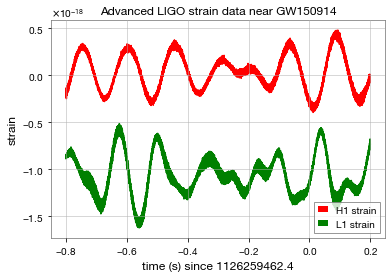

In [6]:
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]
assert 1/dt == sample_rates

# Plot
deltat = 0.5
shiftt = 0.3

indxt = np.where((time >= tevent-deltat-shiftt) & (time < tevent+deltat-shiftt))

plt.figure()
plt.plot(time[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
plt.plot(time[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
try:
    plt.plot(time[indxt]-tevent,strain_V1[indxt],'b',label='V1 strain')
except NameError:
    pass
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('strain')
plt.legend(loc='lower right')
plt.title('Advanced LIGO strain data near '+event_name)
plt.show()

In [7]:
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    freqs1 = np.linspace(0,2048.,Nt//2+1)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

# number of sample for the fast fourier transform:
NFFT = 2* sample_rates
Pxx_H1, freqs = mlab.psd(strain_H1, Fs = sample_rates, NFFT = NFFT)
Pxx_L1, freqs = mlab.psd(strain_L1, Fs = sample_rates, NFFT = NFFT)
try:
    Pxx_V1, freqs = mlab.psd(strain_V1, Fs = sample_rates, NFFT = NFFT)
except NameError:
    pass

# We will use interpolations of the ASDs computed above for whitening:
psd_H1 = interp1d(freqs, Pxx_H1)
psd_L1 = interp1d(freqs, Pxx_L1)
try:
    psd_V1 = interp1d(freqs, Pxx_V1)
except NameError:
    pass

In [8]:
# now whiten the data from H1 and L1, and the template (use H1 PSD):
strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
try:
    strain_V1_whiten = whiten(strain_V1,psd_V1,dt)
except NameError:
    pass

Text(0.5, 1.0, 'Advanced LIGO strain data near GW150914')

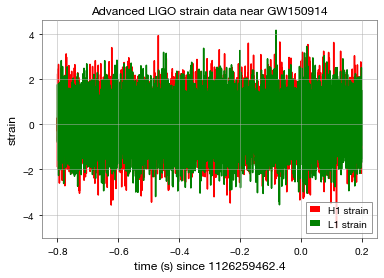

In [9]:
# Plot
deltat = 0.5
shiftt = 0.3

indxt = np.where((time >= tevent-deltat-shiftt) & (time < tevent+deltat-shiftt))

plt.figure()
plt.plot(time[indxt]-tevent,strain_H1_whiten[indxt],'r',label='H1 strain')
plt.plot(time[indxt]-tevent,strain_L1_whiten[indxt],'g',label='L1 strain')
try:
    plt.plot(time[indxt]-tevent,strain_V1_whiten[indxt],'b',label='V1 strain')
except NameError:
    pass
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('strain')
plt.legend(loc='lower right')
plt.title('Advanced LIGO strain data near '+event_name)
plt.show()

In [10]:
# Save GW event
np.savetxt('./{}_H1_{}Hz_{}sec_whiten.txt'.format(event_name, sample_rates, indxt[0].size/sample_rates), np.asarray([time[indxt],strain_H1_whiten[indxt]]).T)
np.savetxt('./{}_L1_{}Hz_{}sec_whiten.txt'.format(event_name, sample_rates, indxt[0].size/sample_rates), np.asarray([time[indxt],strain_L1_whiten[indxt]]).T)
try:
    np.savetxt('./{}_V1_{}Hz_{}sec_whiten.txt'.format(event_name, sample_rates, indxt[0].size/sample_rates), np.asarray([time[indxt],strain_V1_whiten[indxt]]).T)
except NameError:
    pass

In [11]:
# Save noises
deltat = 0.5
shiftt = 0.3
for i in range(1,4+1):
    indxt = np.where((time >= tevent-deltat-(i+0)-shiftt) & (time < tevent+deltat-(i+0)-shiftt))

    # plt.figure()
    # plt.plot(time[indxt]-tevent,strain_H1_whiten[indxt],'r',label='H1 strain')
    # plt.plot(time[indxt]-tevent,strain_L1_whiten[indxt],'g',label='L1 strain')
    # plt.xlabel('time (s) since '+str(tevent))
    # plt.ylabel('strain')
    # plt.legend(loc='lower right')
    # plt.title('Advanced LIGO strain data near '+eventname)
    print(i)
    np.savetxt('./{}noise_{}_H1_{}Hz_{}sec_whiten.txt'.format(event_name, i, sample_rates, indxt[0].size/sample_rates), np.asarray([time[indxt],strain_H1_whiten[indxt]]).T)
    np.savetxt('./{}noise_{}_L1_{}Hz_{}sec_whiten.txt'.format(event_name, i, sample_rates, indxt[0].size/sample_rates), np.asarray([time[indxt],strain_L1_whiten[indxt]]).T)
    try:
        np.savetxt('./{}noise_{}_V1_{}Hz_{}sec_whiten.txt'.format(event_name, i, sample_rates, indxt[0].size/sample_rates), np.asarray([time[indxt],strain_V1_whiten[indxt]]).T)
    except NameError:
        pass        

1
2
3
4
